<a href="https://colab.research.google.com/github/NayeonKeum/SOLUX_summer_data/blob/master/4%EC%A3%BC%EC%B0%A8/%EC%B1%95%ED%84%B03_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# 노트북 안에 그래프를 그리기 위해
%matplotlib inline

# 마이너스 폰트
mpl.rcParams['axes.unicode_minus'] = False

#한글
plt.rc('font',family='NanumBarunGothic')


import warnings
warnings.filterwarnings('ignore')

In [26]:
train = pd.read_csv("/content/drive/My Drive/Colab Notebooks/data/train.csv", parse_dates=["datetime"])
train.shape

(10886, 12)

In [27]:
test = pd.read_csv("/content/drive/My Drive/Colab Notebooks/data/test.csv", parse_dates=["datetime"])
test.shape

(6493, 9)

In [28]:
train["year"] = train["datetime"].dt.year
train["month"] = train["datetime"].dt.month
train["day"] = train["datetime"].dt.day
train["hour"] = train["datetime"].dt.hour
train["minute"] = train["datetime"].dt.minute
train["second"] = train["datetime"].dt.second
train["dayofweek"] = train["datetime"].dt.dayofweek
train.shape

(10886, 19)

In [29]:
test["year"] = test["datetime"].dt.year
test["month"] = test["datetime"].dt.month
test["day"] = test["datetime"].dt.day
test["hour"] = test["datetime"].dt.hour
test["minute"] = test["datetime"].dt.minute
test["second"] = test["datetime"].dt.second
test["dayofweek"] = test["datetime"].dt.dayofweek
test.shape

(6493, 16)

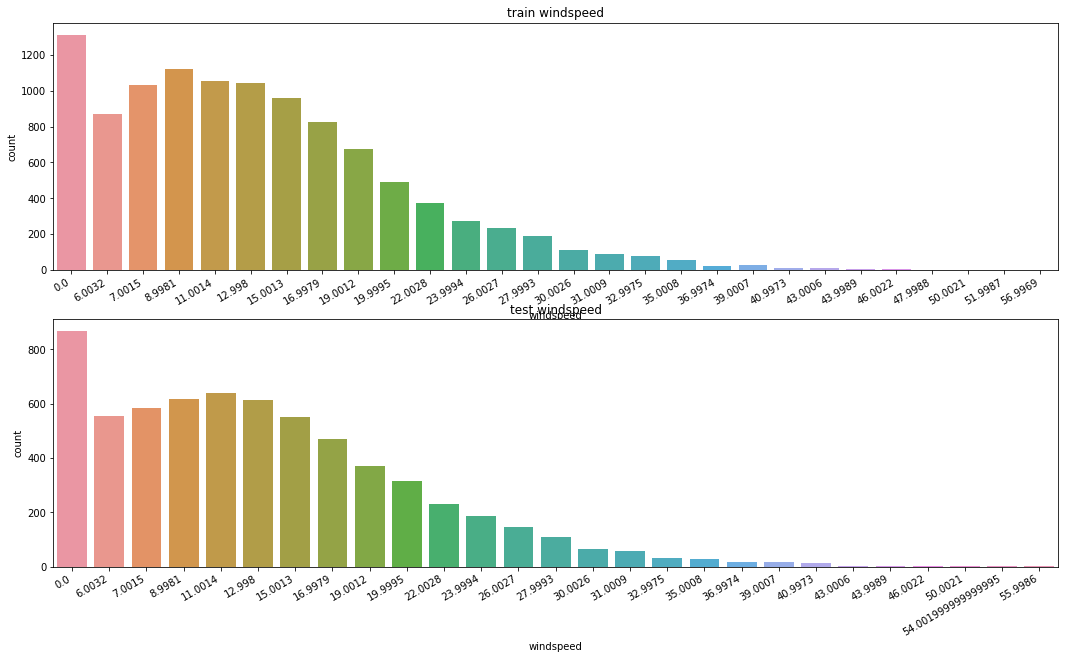

In [30]:
# widspeed 풍속에 0 값이 가장 많다. => 잘못 기록된 데이터를 고쳐 줄 필요가 있음
fig, axes = plt.subplots(nrows=2)
fig.set_size_inches(18,10)

plt.sca(axes[0])
plt.xticks(rotation=30, ha='right')
axes[0].set(ylabel='Count',title="train windspeed")
sns.countplot(data=train, x="windspeed", ax=axes[0])

plt.sca(axes[1])
plt.xticks(rotation=30, ha='right')
axes[1].set(ylabel='Count',title="test windspeed")
sns.countplot(data=test, x="windspeed", ax=axes[1])

In [31]:
# 0값에 특정 값을 넣어준다.
# 평균을 구해 일괄적으로 넣어줄 수도 있지만, 예측의 정확도를 높이는 데 도움이 될것 같진 않다.
# train.loc[train["windspeed"] == 0, "windspeed"] = train["windspeed"].mean()
# test.loc[train["windspeed"] == 0, "windspeed"] = train["windspeed"].mean()

In [32]:
# 풍속이 0인것과 아닌 것의 세트를 나누어 준다.
trainWind0 = train.loc[train['windspeed'] == 0]
trainWindNot0 = train.loc[train['windspeed'] != 0]
print(trainWind0.shape)
print(trainWindNot0.shape)

(1313, 19)
(9573, 19)


In [33]:
# 그래서 머신러닝으로 예측을 해서 풍속을 넣어주도록 한다.
from sklearn.ensemble import RandomForestClassifier

def predict_windspeed(data):
    
    # 풍속이 0인것과 아닌 것
    dataWind0 = data.loc[data['windspeed'] == 0]
    dataWindNot0 = data.loc[data['windspeed'] != 0]
    
    # 예측 피처를 선택
    wCol = ["season", "weather", "humidity", "month", "temp", "year", "atemp"]

    # 0이 아닌 데이터들의 타입을 스트링으로 바꿔준다.
    dataWindNot0["windspeed"] = dataWindNot0["windspeed"].astype("str")

    # 랜덤포레스트 분류기를 사용한다.
    rfModel_wind = RandomForestClassifier()

    # wCol에 있는 피처의 값을 바탕으로 풍속을 학습시킨다.
    rfModel_wind.fit(dataWindNot0[wCol], dataWindNot0["windspeed"])

    # 학습한 값을 바탕으로 풍속이 0으로 기록 된 데이터의 풍속을 예측한다.
    wind0Values = rfModel_wind.predict(X = dataWind0[wCol])

    # 값을 다 예측 후 비교해 보기 위해 예측한 값을 넣어 줄 데이터 프레임을 새로 만든다.
    predictWind0 = dataWind0
    predictWindNot0 = dataWindNot0

    predictWind0["windspeed"] = wind0Values

    # dataWindNot0 0이 아닌 풍속이 있는 데이터프레임에 예측한 값이 있는 데이터프레임을 합쳐준다.
    data = predictWindNot0.append(predictWind0)

    # 풍속의 데이터타입을 float으로 지정해 준다.
    data["windspeed"] = data["windspeed"].astype("float")

    data.reset_index(inplace=True)
    data.drop('index', inplace=True, axis=1)
    
    return data

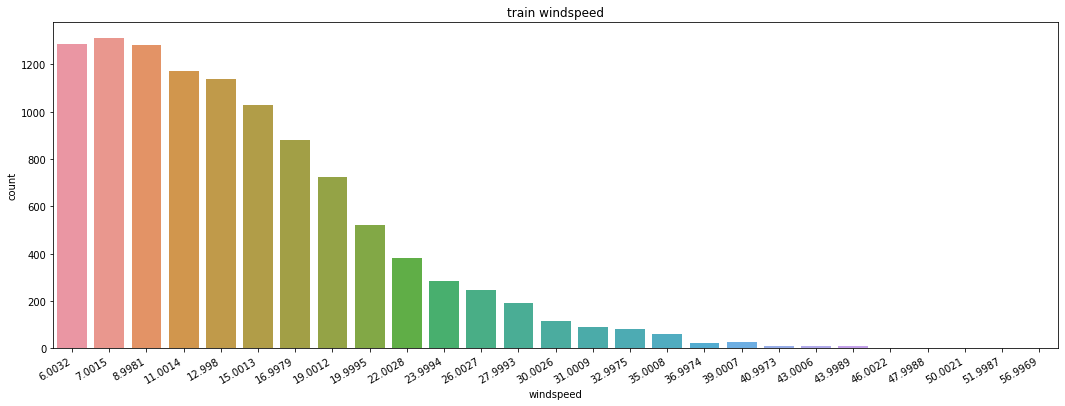

In [34]:
# 0값을 조정
train = predict_windspeed(train)
# test = predict_windspeed(test)

# widspeed 의 0값을 조정한 데이터를 시각화
fig, ax1 = plt.subplots()
fig.set_size_inches(18,6)

plt.sca(ax1)
plt.xticks(rotation=30, ha='right')
ax1.set(ylabel='Count',title="train windspeed")
sns.countplot(data=train, x="windspeed", ax=ax1)

In [35]:
# 연속형 feature = ["temp","humidity","windspeed","atemp"]
# 범주형 feature의 type을 category로 변경 해 준다.
categorical_feature_names = ["season","holiday","workingday","weather",
                             "dayofweek","month","year","hour"]

for var in categorical_feature_names:
    train[var] = train[var].astype("category")
    test[var] = test[var].astype("category")

In [36]:

feature_names = ["season", "weather", "temp", "atemp", "humidity", "windspeed",
                 "year", "hour", "dayofweek", "holiday", "workingday"]

feature_names

['season',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'windspeed',
 'year',
 'hour',
 'dayofweek',
 'holiday',
 'workingday']

In [37]:
X_train = train[feature_names]

print(X_train.shape)
X_train.head()

(10886, 11)


,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,2,9.84,12.880,75,6.0032,2011,5,5,0,0
1,1,1,15.58,19.695,76,16.9979,2011,10,5,0,0
2,1,1,14.76,16.665,81,19.0012,2011,11,5,0,0
3,1,1,17.22,21.210,77,19.0012,2011,12,5,0,0
4,1,2,18.86,22.725,72,19.9995,2011,13,5,0,0


In [38]:
X_test = test[feature_names]

print(X_test.shape)
X_test.head()

(6493, 11)


,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,1,10.66,11.365,56,26.0027,2011,0,3,0,1
1,1,1,10.66,13.635,56,0.0000,2011,1,3,0,1
2,1,1,10.66,13.635,56,0.0000,2011,2,3,0,1
3,1,1,10.66,12.880,56,11.0014,2011,3,3,0,1
4,1,1,10.66,12.880,56,11.0014,2011,4,3,0,1


In [39]:
label_name = "count"

y_train = train[label_name]

print(y_train.shape)
y_train.head()

(10886,)


0     1
1    36
2    56
3    84
4    94
Name: count, dtype: int64

In [40]:
from sklearn.metrics import make_scorer

def rmsle(predicted_values, actual_values):
    # 넘파이로 배열 형태로 바꿔준다.
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)
    
    log_predict = np.log(predicted_values + 1)
    log_actual = np.log(actual_values + 1)
    
    difference = log_predict - log_actual
    # difference = (log_predict - log_actual) ** 2
    difference = np.square(difference)
    
    mean_difference = difference.mean()
    
    score = np.sqrt(mean_difference)
    
    return score

rmsle_scorer = make_scorer(rmsle)
rmsle_scorer

make_scorer(rmsle)

In [41]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

In [42]:
from sklearn.ensemble import RandomForestRegressor

max_depth_list = []
#n_estim 높일수록 정밀도 좋지만 시간 오래 걸림
model = RandomForestRegressor(n_estimators=100,
                              n_jobs=-1,
                              random_state=0)
model

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [43]:
%time score = cross_val_score(model, X_train, y_train, cv=k_fold, scoring=rmsle_scorer)
score = score.mean()
# 0에 근접할수록 좋은 데이터
print("Score= {0:.5f}".format(score))

CPU times: user 3.26 s, sys: 619 ms, total: 3.88 s
Wall time: 30.2 s
Score= 0.33080


In [44]:
# 학습시킴, 피팅(옷을 맞출 때 사용하는 피팅을 생각함) - 피처와 레이블을 넣어주면 알아서 학습을 함
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [45]:
# 예측
predictions = model.predict(X_test)

print(predictions.shape)
predictions[0:10]

(6493,)


array([ 12.58,   5.07,   3.98,   3.42,   3.18,   6.27,  38.02, 105.47,
       237.13, 136.64])

[Text(0.5, 1.0, 'test')]

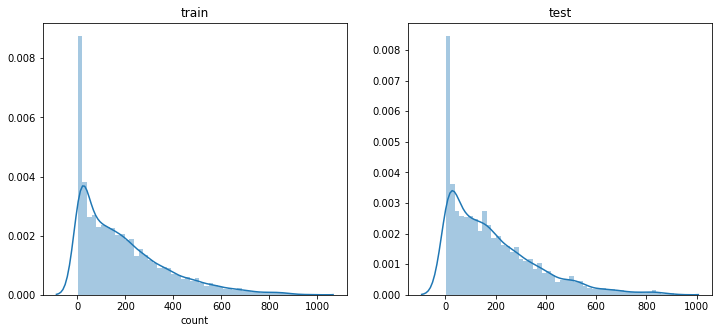

In [46]:
# 예측한 데이터를 시각화 해본다. 
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(y_train,ax=ax1,bins=50)
ax1.set(title="train")
sns.distplot(predictions,ax=ax2,bins=50)
ax2.set(title="test")

In [47]:
submission = pd.read_csv("/content/drive/My Drive/Colab Notebooks/data/sampleSubmission.csv")
submission

submission["count"] = predictions

print(submission.shape)
submission.head()

(6493, 2)


,datetime,count
0,2011-01-20 00:00:00,12.58
1,2011-01-20 01:00:00,5.07
2,2011-01-20 02:00:00,3.98
3,2011-01-20 03:00:00,3.42
4,2011-01-20 04:00:00,3.18


In [49]:

submission.to_csv("/content/drive/My Drive/Colab Notebooks/data/Score_{0:.5f}_submission.csv".format(score), index=False)

In [50]:
431/3501

0.12310768351899458